In [1]:
import os
import argparse
import torch as th
import torch.nn.functional as F
import time
import conf_mgt
from utils import yamlread
from guided_diffusion import dist_util
from tqdm import tqdm
# Workaround
try:
    import ctypes
    libgcc_s = ctypes.CDLL('libgcc_s.so.1')
except:
    pass


from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    classifier_defaults,
    create_model_and_diffusion,
    create_classifier,
    select_args,
)  # noqa: E402

from guided_diffusion.script_util import (
    sr_model_and_diffusion_defaults,
    sr_create_model_and_diffusion,
)
def toU8(sample):
    if sample is None:
        return sample

    sample = ((sample + 1) * 127.5).clamp(0, 255).to(th.uint8)
    sample = sample.permute(0, 2, 3, 1)
    sample = sample.contiguous()
    sample = sample.detach().cpu().numpy()
    return sample

import torch
import torchvision.transforms as T

In [2]:
intermediate_steps = False #return intermediate results (usefull to create gifs, but will use lot of memory - around 3GB for one 256x256 image)
conf = conf_mgt.conf_base.Default_Conf()
conf.update(yamlread('confs/my_conf-2.yml'))
print(conf.inpa_inj_sched_prev) #Are you about to use RePainting ?print(conf.diffusion_steps) #may not be the good one
conf.intermediate_steps = intermediate_steps
print(conf.intermediate_steps)


True
False


In [3]:
print("Start", conf['name'])

device = dist_util.dev(conf.get('device'))


model, diffusion = create_model_and_diffusion(
    **select_args(conf, model_and_diffusion_defaults().keys()), conf=conf
)


Start my_conf


In [4]:
model.load_state_dict(
    dist_util.load_state_dict(os.path.expanduser(
        conf.model_path), map_location="cpu")
)
model.to(device)
if conf.use_fp16:
    model.convert_to_fp16()
model.eval()

show_progress = conf.show_progress

import numpy as np
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Nombre de paramètres : ', params)

Nombre de paramètres :  552814086


In [ ]:
# https://colab.research.google.com/drive/12a_Wrfi2_gwwAuN3VvMTwVMz9TfqctNj#scrollTo=7zAqFEykBHDL TO DO

In [5]:

cond_fn = None

def model_fn(x, t, y=None, gt=None, **kwargs):
    assert y is not None
    return model(x, t, y if conf.class_cond else None, gt=gt)

In [6]:
dset = 'eval'

eval_name = conf.get_default_eval_name()

IMAGE_SIZE = 256
GT_PATH = './data/datasets/gts/dogs'
MASK_PATH = './data/datasets/gt_keep_masks/genhalf'
dataconfig = {'mask_loader': True,
 'gt_path': GT_PATH,
 'mask_path': MASK_PATH,
 'image_size': IMAGE_SIZE,
 'class_cond': False,
 'deterministic': True, # Pas de shuffle dans le dataloader
 'random_crop': False, # Crop (au lieu de redimensionner l'image). Non Implémenté.
 'random_flip': False,
 'return_dict': True,
 'drop_last': False,
 'batch_size': 1,
 'return_dataloader': True,
 'offset': 0,
 'max_len': None,
 'paths': {'srs': './log/face_example/inpainted',
  'lrs': './log/face_example/gt_masked',
  'gts': './log/face_example/gt',
  'gt_keep_masks': './log/face_example/gt_keep_mask'}
             }

conf['data']['eval'][eval_name] = dataconfig

return_all = True
conf.intermediate_steps = True
path_save_checkpoint = './data/datasets/gts/dogs/checkpoints/'
path_save_finals = './inpainted/dogs/finals/'
format_save = '.png'
transform = T.ToPILImage()
def tou8batch(result,return_all=False):
    if return_all:
        finals = result[1]['sample']
    else:
        finals = result
    finals = ((finals + 1) * 127.5).clamp(0, 255).to(th.uint8)
    finals = finals.contiguous()
    return(finals)

In [7]:
from guided_diffusion.scheduler import get_schedule_jump
from matplotlib import pyplot as plt
import numpy as np


if conf.schedule_jump_params:
            times = get_schedule_jump(**conf.schedule_jump_params)

            time_pairs = list(zip(times[:-1], times[1:]))
            time_pairs = np.array(time_pairs)
            allowed = [0 if i[0]<i[1] else 1 for i in time_pairs]
            
to_save = (190*np.array(range(23))+200) #Indexes of steps we want to save. It is every 10 diffusion reverse, for conf jump : 250,10,10.

In [8]:
for j in range(30):
    dl = conf.get_dataloader(dset=dset, dsName=eval_name)
    for batch in iter(dl):
            img = batch['GT'].to(device)
            mask = batch['gt_keep_mask'].to(device)
            name = batch['GT_name'][0][:-4]
            model_kwargs = {}
            model_kwargs["gt"] = img
            model_kwargs['y'] = 'SALUT LOLOL' #Utile seulement si conf.cond_y (voir model_fn au dessus). Doit être défini.
            model_kwargs['gt_keep_mask'] = mask
            model_kwargs['stop_to'] = None
            model_kwargs['starting_point'] = None
            batch_size = model_kwargs['gt'].shape[0]

            sample_fn = (
                diffusion.p_sample_loop if not conf.use_ddim else diffusion.ddim_sample_loop
            )

            result = sample_fn(
                model_fn,
                (batch_size, 3, conf.image_size, conf.image_size),
                clip_denoised=conf.clip_denoised,
                model_kwargs=model_kwargs,
                cond_fn=cond_fn,
                device=device,
                progress=show_progress,
                return_all=return_all,
                conf=conf
            )



            #save checkpoints
            for i in to_save:
                assert allowed[i] #check we are about to reverse diffusion
                torch.save(result[0][i].cpu().detach(),f=path_save_checkpoint+name+'_'+str(j)+'_'+str(i) + '.pt')

            #save final image
            img_last = transform(tou8batch(result[0][-1].cpu().detach())[0])
            img_last.save(path_save_finals+name+'_'+str(j)+format_save)

            del result #clear GPU memory
            torch.cuda.empty_cache()


passing
passing
passing
passing
passing
passing
passing
passing


  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

  0%|          | 0/4570 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [37]:
model_kwargs['stop_to'] = None
model_kwargs['starting_point'] = {'x':result[-3],'step':1998} #not all values are possible due to out['pred_xstart'] variable (xt-1) which is needed to add noise (forward diffusion). Otherwise we need to keep track of pred_xstart for each case (intermediate_steps,return_all,...).

return_all = False
result_bis = sample_fn(
    model_fn,
    (batch_size, 3, conf.image_size, conf.image_size),
    clip_denoised=conf.clip_denoised,
    model_kwargs=model_kwargs,
    cond_fn=cond_fn,
    device=device,
    progress=show_progress,
    return_all=return_all,
    conf=conf
)


  0%|          | 0/2572 [00:00<?, ?it/s]

In [1]:
result[-3]

NameError: name 'result' is not defined

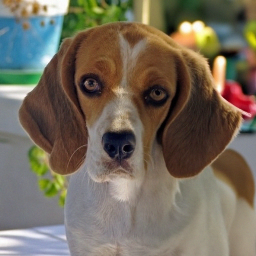

In [47]:
i = 2500
img = result_bis[0][i]
y = tou8batch(img)
transform(y[0])

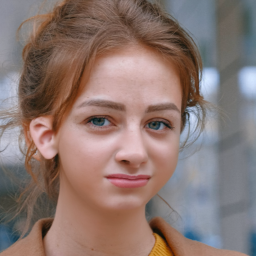

In [33]:
y = tou8batch(result_bis)
transform(y[1])

In [66]:
del result

torch.cuda.empty_cache()
!nvidia-smi

Sat Dec 24 00:20:22 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 30%   30C    P8    10W / 200W |   6381MiB /  8192MiB |     12%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [17]:





if conf.name=='my_conf':
    result = result[1] #0 is all tuples to generate gifs
srs = toU8(result['sample'])
gts = toU8(result['gt'])
lrs = toU8(result.get('gt') * model_kwargs.get('gt_keep_mask') + (-1) *
           th.ones_like(result.get('gt')) * (1 - model_kwargs.get('gt_keep_mask')))

gt_keep_masks = toU8((model_kwargs.get('gt_keep_mask') * 2 - 1))

conf.eval_imswrite(
    srs=srs, gts=gts, lrs=lrs, gt_keep_masks=gt_keep_masks,
    img_names=batch['GT_name'], dset=dset, name=eval_name, verify_same=False)

  0%|          | 0/4570 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [22]:
    srs = toU8(result[1]['sample'])
    gts = toU8(result[1]['gt'])
    lrs = toU8(result[1].get('gt') * model_kwargs.get('gt_keep_mask') + (-1) *
               th.ones_like(result[1].get('gt')) * (1 - model_kwargs.get('gt_keep_mask')))

    gt_keep_masks = toU8((model_kwargs.get('gt_keep_mask') * 2 - 1))

    conf.eval_imswrite(
        srs=srs, gts=gts, lrs=lrs, gt_keep_masks=gt_keep_masks,
        img_names=batch['GT_name'], dset=dset, name=eval_name, verify_same=False)

In [24]:
lrs

array([[[[143, 144, 156],
         [140, 142, 154],
         [144, 145, 157],
         ...,
         [104, 120, 130],
         [105, 121, 132],
         [104, 120, 131]],

        [[142, 143, 155],
         [141, 143, 155],
         [142, 143, 155],
         ...,
         [104, 120, 130],
         [102, 118, 129],
         [103, 119, 130]],

        [[142, 144, 156],
         [142, 143, 155],
         [142, 144, 156],
         ...,
         [101, 118, 129],
         [100, 118, 130],
         [103, 120, 131]],

        ...,

        [[153, 127, 116],
         [169, 134, 117],
         [168, 133, 114],
         ...,
         [ 37,  80, 104],
         [ 33,  82, 107],
         [ 31,  84, 111]],

        [[168, 130, 116],
         [173, 132, 117],
         [171, 132, 117],
         ...,
         [ 36,  81, 104],
         [ 33,  83, 107],
         [ 32,  86, 112]],

        [[169, 133, 113],
         [169, 133, 115],
         [167, 128, 113],
         ...,
         [ 35,  82, 104],
        